In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors # for player to grid assignment
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as patches


In [2]:
# Read In csvs
folder = '/kaggle/input/nfl-big-data-bowl-2025/'
games = pd.read_csv(folder + "games.csv")
plays = pd.read_csv(folder + "plays.csv")
players = pd.read_csv(folder + "players.csv")
player_play = pd.read_csv(folder+"player_play.csv")

In [3]:
# full_tracking_data = pd.concat([pd.read_csv(folder + "tracking_week_1.csv"),
#                                 pd.read_csv(folder + "tracking_week_2.csv"),
#                                 pd.read_csv(folder + "tracking_week_3.csv"),
#                                 pd.read_csv(folder + "tracking_week_4.csv"),
#                                 pd.read_csv(folder + "tracking_week_5.csv"),
#                                 pd.read_csv(folder + "tracking_week_6.csv"),
#                                 pd.read_csv(folder + "tracking_week_7.csv"),
#                                 pd.read_csv(folder + "tracking_week_8.csv"),
#                                 pd.read_csv(folder + "tracking_week_9.csv")],
#                              ignore_index=True)
# full_tracking_data.to_feather('full_tracking_data.feather')
# full_tracking_data.shape

In [4]:
full_tracking_data = pd.read_feather('/kaggle/input/full-tracking-data/full_tracking_data.feather')
full_tracking_data.shape

(59327373, 18)

In [5]:
def get_mature_matrices_dict_old():
    mature_frames = 28
    print("Pre-processing Data...")
    # Get the plays that were passing plays
    passing_plays = plays[plays['isDropback']==True]
    # Get what players ran a route in the passing plays
    route_runners = player_play[(player_play['gameId'].isin(passing_plays['gameId'])) & (player_play['playId'].isin(passing_plays['playId'])) & (player_play['wasRunningRoute'] == True)]
    # Get their tracking data
    route_runner_tracking = full_tracking_data.merge(route_runners[['gameId', 'playId', 'nflId']], on=['gameId', 'playId', 'nflId'])
    # Figure out what frame the ball was snapped on
    result = (
        route_runner_tracking[route_runner_tracking['event'] == 'ball_snap']
        .groupby(['gameId', 'playId'])['frameId']
        .first()  # Get the first frameId for ball_snap
        .reset_index()
    )
    # Figure out which frame the play matured by
    route_runner_tracking['mature_frame'] = route_runner_tracking['frameId'] + mature_frames
    # Get the play where the frame was mature or the ball was passed, whichever came first
    route_runner_tracking = route_runner_tracking[(route_runner_tracking['event'].isin(['pass_forward','autoevent_passforward']))|(route_runner_tracking['frameId'] == route_runner_tracking['mature_frame'])]
    route_runner_tracking = (
        route_runner_tracking.groupby(['gameId', 'playId'])[['gameId', 'playId','frameId','playDirection','x','y']]
        .apply(lambda x: x[x['frameId'] == x['frameId'].min()])
        .reset_index(drop=True)
    )

    # We're losing around 1000 passing plays for some reason
    # probably scrambles and sacks
    #print(len(route_runner_tracking[['gameId','playId','frameId']].drop_duplicates()),len(passing_plays))
    
    print("Main Loop...")
    mature_matrices_dict = {}
    tracking_grouped = route_runner_tracking.groupby(['gameId','playId'])
    plays_grouped = passing_plays.groupby(['gameId','playId'])
    for key,group in tqdm(tracking_grouped):
        group = group.copy()
        play_info = plays_grouped.get_group(key)
        LoS = play_info['absoluteYardlineNumber'].values[0] # Line of Scrimmage

        max_x, max_y = 120, 53.3
        if group['playDirection'].values[0] == 'left':
            # rotate if needed
            LoS = max_x - LoS
            group['x'] = max_x - group['x']
            group['y'] = max_y - group['y']

        # Get which depth section the players were in 
        group['depth'] = group['x'].apply(lambda x:2 if x <= LoS + 10 else (1 if x <= LoS + 20 else 0))

        # Get which section the players were in horizontally across the field
        group['horizontal'] = group['y'].apply(lambda x: 
        4 if x <= 9 else  # lower numbers yard line  #! I think this should be 10?
        (3 if x <= 20 else  # lower hash yard line
         (2 if x <= 33.3 else  # upper hash yard line
          (1 if x <= 44.3 else  # upper numbers yard line  
           0))))
        
        # Initialize the matrix
        mat = np.zeros((3,5))
        for _, row in group.iterrows():
            depth_idx = row['depth']
            horizontal_idx = row['horizontal']
            
            # Increment the corresponding matrix cell
            mat[depth_idx, horizontal_idx] += 1
    
        ## left to right: decreasing y
        ## top to bottom: decreasing x
        ## So, bottom row is within 10 yards of line of scrimmage
        ## Middle column is between the hashes
        
        #print(mat)
        
        mature_matrices_dict[key] = mat


    # Initialize a matrix to hold the sum of all matrices
    sum_matrix = np.zeros_like(list(mature_matrices_dict.values())[0], dtype=float)
    
    # Iterate over the dictionary and sum all matrices element-wise
    for matrix in mature_matrices_dict.values():
        sum_matrix += matrix
    
    # Calculate the average by dividing by the number of matrices
    num_matrices = len(mature_matrices_dict)
    average_matrix = sum_matrix / num_matrices
    print("Average Matrix:")
    print(average_matrix)
    
    # Initialize the first matrix from the dictionary as the base
    max_matrix = list(mature_matrices_dict.values())[0]
    
    # Iterate over the dictionary and calculate the element-wise maximum across all matrices
    for matrix in mature_matrices_dict.values():
        max_matrix = np.maximum(max_matrix, matrix)
    
    # Print the result
    print("Max Matrix:")
    print(max_matrix)

    print("First Matrix:")
    print(list(mature_matrices_dict.values())[0])
    print("First Matrix Flattened:")
    print(list(mature_matrices_dict.values())[0].flatten())
    return mature_matrices_dict

In [6]:
def get_mature_matrices_dict(cutoffs = [10,20],y_cutoffs = [9,20,33.3,44.3],type='yards'):
    mature_frames = 28
    print("Pre-processing Data...")
    # Get the plays that were passing plays
    passing_plays = plays[plays['isDropback']==True]
    # Get what players ran a route in the passing plays
    route_runners = player_play[(player_play['gameId'].isin(passing_plays['gameId'])) & (player_play['playId'].isin(passing_plays['playId'])) & (player_play['wasRunningRoute'] == True)]
    # Get their tracking data
    route_runner_tracking = full_tracking_data.merge(route_runners[['gameId', 'playId', 'nflId']], on=['gameId', 'playId', 'nflId'])
    # Figure out what frame the ball was snapped on
    result = (
        route_runner_tracking[route_runner_tracking['event'] == 'ball_snap']
        .groupby(['gameId', 'playId'])['frameId']
        .first()  # Get the first frameId for ball_snap
        .reset_index()
    )
    # Figure out which frame the play matured by
    route_runner_tracking['mature_frame'] = route_runner_tracking['frameId'] + mature_frames
    # Get the play where the frame was mature or the ball was passed, whichever came first
    route_runner_tracking = route_runner_tracking[(route_runner_tracking['event'].isin(['pass_forward','autoevent_passforward']))|(route_runner_tracking['frameId'] == route_runner_tracking['mature_frame'])]
    route_runner_tracking = (
        route_runner_tracking.groupby(['gameId', 'playId'])[['gameId', 'playId','frameId','playDirection','x','y']]
        .apply(lambda x: x[x['frameId'] == x['frameId'].min()])
        .reset_index(drop=True)
    )

    # We're losing around 1000 passing plays for some reason
    # probably scrambles and sacks
    #print(len(route_runner_tracking[['gameId','playId','frameId']].drop_duplicates()),len(passing_plays))
    
    print("Main Loop...")
    mature_matrices_dict = {}
    tracking_grouped = route_runner_tracking.groupby(['gameId','playId'])
    plays_grouped = passing_plays.groupby(['gameId','playId'])
    for key,group in tqdm(tracking_grouped):
        group = group.copy()
        play_info = plays_grouped.get_group(key)
        LoS = play_info['absoluteYardlineNumber'].values[0] # Line of Scrimmage
        ydstogo = play_info['yardsToGo'].values[0]
        max_x, max_y = 120, 53.3
        if group['playDirection'].values[0] == 'left':
            # rotate if needed
            LoS = max_x - LoS
            group['x'] = max_x - group['x']
            group['y'] = max_y - group['y']

        # Get which depth section the players were in 
        final_cuts = [None] * (len(cutoffs))
        for i in range(len(cutoffs)):
            if type == 'yards':
                final_cuts[i] = cutoffs[i]
            elif type == '%_ydstogo':
                final_cuts[i] = cutoffs[i] * ydstogo
                
        def get_depth_groups(x,LoS,final_cuts):
            for i in range(len(final_cuts)):
                if x <= LoS + final_cuts[i]:
                    return len(final_cuts) - i
            return 0
        group['depth'] = group['x'].apply(lambda x:get_depth_groups(x,LoS,final_cuts))


        def get_horizontal_groups(y,y_cutoffs):
            for i in range(len(y_cutoffs)):
                if y <= y_cutoffs[i]:
                    return len(y_cutoffs) - i
            return 0
        # Get which section the players were in horizontally across the field
        group['horizontal'] = group['y'].apply(lambda y:get_horizontal_groups(y,y_cutoffs))
        
        # Initialize the matrix
        mat = np.zeros((len(cutoffs) + 1,len(y_cutoffs)+1))
        for _, row in group.iterrows():
            depth_idx = row['depth']
            horizontal_idx = row['horizontal']
            
            # Increment the corresponding matrix cell
            mat[depth_idx, horizontal_idx] += 1
    
        ## left to right: decreasing y
        ## top to bottom: decreasing x
        ## So, bottom row is within 10 yards of line of scrimmage
        ## Middle column is between the hashes
        
        #print(mat)
        
        mature_matrices_dict[key] = mat


    # Initialize a matrix to hold the sum of all matrices
    sum_matrix = np.zeros_like(list(mature_matrices_dict.values())[0], dtype=float)
    
    # Iterate over the dictionary and sum all matrices element-wise
    for matrix in mature_matrices_dict.values():
        sum_matrix += matrix
    
    # Calculate the average by dividing by the number of matrices
    num_matrices = len(mature_matrices_dict)
    average_matrix = sum_matrix / num_matrices
    print("Average Matrix:")
    print(average_matrix)
    
    # Initialize the first matrix from the dictionary as the base
    max_matrix = list(mature_matrices_dict.values())[0]
    
    # Iterate over the dictionary and calculate the element-wise maximum across all matrices
    for matrix in mature_matrices_dict.values():
        max_matrix = np.maximum(max_matrix, matrix)
    
    # Print the result
    print("Max Matrix:")
    print(max_matrix)

    print("First Matrix:")
    print(list(mature_matrices_dict.values())[0])
    print("First Matrix Flattened:")
    print(list(mature_matrices_dict.values())[0].flatten())
    return mature_matrices_dict

In [7]:
## These should be the same
d = get_mature_matrices_dict_old()
d = get_mature_matrices_dict(cutoffs = [10,20],type='yards',y_cutoffs = [9,20,33.3,44.3])

Pre-processing Data...
Main Loop...


100%|██████████| 8647/8647 [00:17<00:00, 490.29it/s]


Average Matrix:
[[0.01364635 0.03064647 0.03238117 0.02671447 0.01607494]
 [0.09957211 0.24794726 0.25465479 0.2681855  0.1037354 ]
 [0.25361397 1.         0.97455765 1.0233607  0.24898809]]
Max Matrix:
[[2. 3. 3. 3. 2.]
 [2. 3. 3. 3. 2.]
 [3. 4. 5. 4. 2.]]
First Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 2. 0.]]
First Matrix Flattened:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0.]
Pre-processing Data...
Main Loop...


100%|██████████| 8647/8647 [00:17<00:00, 505.31it/s]

Average Matrix:
[[0.01364635 0.03064647 0.03238117 0.02671447 0.01607494]
 [0.09957211 0.24794726 0.25465479 0.2681855  0.1037354 ]
 [0.25361397 1.         0.97455765 1.0233607  0.24898809]]
Max Matrix:
[[2. 3. 3. 3. 2.]
 [2. 3. 3. 3. 2.]
 [3. 4. 5. 4. 2.]]
First Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 2. 0.]]
First Matrix Flattened:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0.]


In [8]:
d = get_mature_matrices_dict(cutoffs = [5,10,20],type='yards')

Pre-processing Data...
Main Loop...


100%|██████████| 8647/8647 [00:16<00:00, 508.84it/s]


Average Matrix:
[[0.01364635 0.03064647 0.03238117 0.02671447 0.01607494]
 [0.09957211 0.24794726 0.25465479 0.2681855  0.1037354 ]
 [0.12570834 0.29594079 0.28090667 0.31814502 0.12362669]
 [0.12790563 0.70405921 0.69365098 0.70521568 0.1253614 ]]
Max Matrix:
[[2. 3. 3. 3. 2.]
 [2. 3. 3. 3. 2.]
 [2. 3. 3. 3. 2.]
 [3. 4. 4. 4. 2.]]
First Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
First Matrix Flattened:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


In [9]:
d = get_mature_matrices_dict(cutoffs = [.2,.8,1.2],type='%_ydstogo')

Pre-processing Data...
Main Loop...


100%|██████████| 8647/8647 [00:16<00:00, 508.73it/s]

Average Matrix:
[[0.11691916 0.29825373 0.31652596 0.3190702  0.12432057]
 [0.06904129 0.18746386 0.18596045 0.19232104 0.0703134 ]
 [0.12489881 0.4011796  0.37296172 0.41413207 0.12605528]
 [0.05597317 0.39169654 0.38614548 0.39273737 0.04810917]]
Max Matrix:
[[2. 3. 4. 3. 3.]
 [1. 2. 2. 2. 2.]
 [2. 3. 3. 3. 2.]
 [2. 4. 4. 4. 2.]]
First Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0.]]
First Matrix Flattened:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0. 0. 0. 0. 0. 0.]


In [10]:
def get_grids_and_labels(games, plays, full_tracking_data,mature_matrices_dict, square_length_x = 1, square_length_y = 1):
    '''
    This function is an optimized combination of get_play_locations and get_binary_matrix designed to run on the full dataset at once
    '''
    grids = []
    other_x = []
    labels = []
    ids = []
    
    # Filter down to only what we need
    temp_tracking = full_tracking_data[((full_tracking_data['displayName'] == 'football') & (full_tracking_data['frameId'] == 1)) | ((full_tracking_data['event'] == 'ball_snap') & (full_tracking_data['displayName']!='football'))]
    
    # Group the dataframes for faster lookup
    games_grouped = games.groupby('gameId')
    plays_grouped = plays.groupby(['gameId','playId'])
    temp_tracking_grouped = temp_tracking.groupby(['gameId','playId'])

    ## Precompute some other stuff
    
    
    x_range = np.arange(-10, 1, square_length_x)  # Horizontal range of the field
    y_range = np.arange(-33, 34, square_length_y)  # Vertical range of the field
    
    # Generate grid centers using np.meshgrid for more efficient generation
    x_centers, y_centers = np.meshgrid(x_range + square_length_x / 2, y_range + square_length_y / 2)
    grid_centers = np.column_stack([x_centers.ravel(), y_centers.ravel()])  # Flatten the arrays
    
    # Use NearestNeighbors for faster square assignment
    tree = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(grid_centers)
    
    # Calculate binary matrix dimensions
    num_rows = int(np.ceil((y_range[-1] - y_range[0]) / square_length_y))
    num_cols = int(np.ceil((x_range[-1] - x_range[0]) / square_length_x))

    # Map grid centers to binary matrix
    mapping = {}
    for i, (x, y) in enumerate(grid_centers):
        row = int((y_range[-1] - y) // square_length_y)
        col = int((x - x_range[0]) // square_length_x)
        mapping[i] = (row,col)
    
    man_zone_mapping = plays['pff_manZone'].fillna('None').value_counts().to_dict()
    for i,v in enumerate(man_zone_mapping.keys()):
        man_zone_mapping[v] = i
    
    pass_coverage_mapping = plays['pff_passCoverage'].fillna('None').value_counts().to_dict()
    for i,v in enumerate(pass_coverage_mapping.keys()):
        pass_coverage_mapping[v] = i

    for key,grouped in tqdm(temp_tracking_grouped):
        
        if len(grouped) == 1: # this only happens if the ball wasn't snapped
            continue 
            
        play_information = plays_grouped.get_group(key)
        if play_information['qbSpike'].values[0]==1 or play_information['qbKneel'].values[0]==1: # don't deal with spikes and kneels
            continue

        if key not in mature_matrices_dict.keys(): # It's not a passing play we have data for
            continue
        
        posteam = play_information['possessionTeam'].values[0]
        offense = grouped[grouped['club'].isin([posteam,'football'])].copy()

        yardline = play_information['absoluteYardlineNumber'].values[0] # Distance from end zone for possession team

        max_x, max_y = 120, 53.3
        if offense['playDirection'].values[0] == 'left':
            # rotate
            offense['x'] = max_x - offense['x']
            offense['y'] = max_y - offense['y']

            yardline = max_x - yardline
    
        
        ball = offense[offense['displayName']=='football']
        offense = offense[offense['displayName']!='football']
        
        offense[['x', 'y']] -= [ball['x'].values[0], ball['y'].values[0]]
        offense = offense[['x', 'y']]
        player_coords = offense.values
    
        if np.any(player_coords[:, 0] >= 0):
            # Calculate the shift: how much to subtract to make all x values negative
            shift_amount = np.max(player_coords[:, 0]) + .01 # + 0.01 to make sure everything is strictly negative
            player_coords[:, 0] -= shift_amount
        
        distances, indices = tree.kneighbors(player_coords)
    
        offense['square_idx'] = indices.ravel()
        offense['assigned_square_x'], offense['assigned_square_y'] = grid_centers[indices.ravel()].T
    
    
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
    
        # Map grid centers to binary matrix using precomputed assignments:
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
        player_square_indices = offense['square_idx'].values    
        for i in player_square_indices:
            row,col = mapping[i]
            binary_matrix[row, col] = 1


        ## The other information we will provide the model to predict the type of play
        
        # Score Differential
        hometeam = games_grouped.get_group(key[0])['homeTeamAbbr'].values[0]
        posteam_is_hometeam = posteam == hometeam
        # score differential is the posteam's score - defteam's score
        #print(play_information['preSnapHomeScore'].values[0], play_information['preSnapVisitorScore'].values[0])
        score_differential = (play_information['preSnapHomeScore'].values[0] - play_information['preSnapVisitorScore'].values[0] 
                              if posteam_is_hometeam else
                              play_information['preSnapVisitorScore'].values[0] - play_information['preSnapHomeScore'].values[0]) 
        
        # Yardline
        # (calculated earlier)

        
        # Yards to go
        ydstogo = play_information['yardsToGo'].values[0]

        # Down
        down = play_information['down'].values[0]

        # Quarter
        quarter = play_information['quarter'].values[0]

        # Seconds on Game Clock
        clock = play_information['gameClock'].values[0]
        split = clock.split(':')
        secs_left = int(split[0]) * 60 + int(split[1])

        def_formation = play_information['pff_passCoverage'].fillna('None').values[0]
        pass_coverage = np.zeros(len(pass_coverage_mapping))
        pass_coverage[pass_coverage_mapping[def_formation]] = 1

        man_zone_play = play_information['pff_manZone'].fillna('None').values[0]
        man_zone = np.zeros(len(man_zone_mapping))
        man_zone[man_zone_mapping[man_zone_play]] = 1

        other_information = [score_differential,yardline,ydstogo,down,quarter,secs_left]
        other_information.extend(pass_coverage)
        other_information.extend(man_zone)

        other_information = torch.tensor(np.array(other_information),dtype=torch.float32)

        other_x.append(other_information)
        grids.append(torch.tensor(binary_matrix, dtype=torch.float32))
        labels.append(torch.tensor(np.clip(mature_matrices_dict[key], 0, 1),dtype=torch.float32))
        ids.append([play_information['gameId'].values[0],play_information['playId'].values[0]])

    return grids,labels,other_x, ids


In [11]:
def precompute_data(games,plays, full_tracking_data,mature_matrices_dict, save_path="precomputed_data.pt"):
    """
    Precomputes binary matrices and labels, saves them to a file, and returns them as tensors.
    
    Args:
        plays (pd.DataFrame): The plays dataframe containing play information.
        full_tracking_data (pd.DataFrame): The full tracking data containing player locations.
        save_path (str): Path to save the precomputed data.        
    Returns:
        Tuple: (grids, encoded_labels, le, grid_shape)
    """
    
    grids, labels, other_x, ids = get_grids_and_labels(games,plays,full_tracking_data,mature_matrices_dict)

    
    # Save data
    torch.save((grids, labels,other_x, grids[0].shape, ids), save_path)
    return grids, labels,other_x, grids[0].shape, ids

def setup_data_from_precomputed(save_path="precomputed_data.pt",split_type='random', test_split=0.3, batch_size=32,train_flip=False,test_flip=False):
    """
    Loads precomputed data and splits it into train, validation, and test sets.
    """
    # Load precomputed data
    grids, labels, other_x, shape, ids = torch.load(save_path, weights_only=False)  # Ensure correct unpacking

    # Split data
    if split_type=='random':
        X_train, X_temp, y_train, y_temp, other_x_train, other_x_temp, id_train, id_temp = train_test_split(
            grids, labels, other_x, ids, test_size=test_split, random_state=42
        )
        X_val, X_test, y_val, y_test, other_x_val, other_x_test, id_val, id_test = train_test_split(
            X_temp, y_temp, other_x_temp, id_temp, test_size=0.5, random_state=42
        )
    elif split_type == 'week':
        train_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([1,2,3,4,5])]['gameId'])
        X_train = [grid for grid, include in zip(grids, train_mask) if include]
        y_train = [label for label, include in zip(labels, train_mask) if include]
        other_x_train = [other_x_i for other_x_i, include in zip(other_x, train_mask) if include]
        id_train = [id for id, include in zip(ids, train_mask) if include]
        
        
        val_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([6,7])]['gameId'])
        X_val = [grid for grid, include in zip(grids, val_mask) if include]
        y_val = [label for label, include in zip(labels, val_mask) if include]
        other_x_val = [other_x_i for other_x_i, include in zip(other_x, val_mask) if include]
        id_val = [id for id, include in zip(ids, val_mask) if include]
        
        test_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([8,9])]['gameId'])
        X_test = [grid for grid, include in zip(grids, test_mask) if include]
        y_test = [label for label, include in zip(labels, test_mask) if include]
        other_x_test = [other_x_i for other_x_i, include in zip(other_x, test_mask) if include]
        id_test = [id for id, include in zip(ids, test_mask) if include]
    elif split_type == 'game':
        # Step 1: Get unique IDs
        unique_ids = pd.DataFrame(ids)[0].drop_duplicates()
        
        # Step 2: Randomly shuffle the unique IDs
        shuffled_ids = unique_ids.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Step 3: Split the shuffled list into 80%, 5%, and 15%
        n = len(shuffled_ids)
        train_ids = shuffled_ids[:int(1-test_split * n)]  # 80%
        val_ids = shuffled_ids[int(1-test_split * n):int(1-test_split/2 * n)]  # 5%
        test_ids = shuffled_ids[int(1-test_split/2 * n):]  # 15%
        
        
        train_mask = [id[0] in set(train_ids) for id in ids]
        X_train = [grid for grid, include in zip(grids, train_mask) if include]
        y_train = [label for label, include in zip(labels, train_mask) if include]
        other_x_train = [other_x_i for other_x_i, include in zip(other_x, train_mask) if include]
        id_train = [id for id, include in zip(ids, train_mask) if include]
        
        val_mask = [id[0] in set(val_ids) for id in ids]
        X_val = [grid for grid, include in zip(grids, val_mask) if include]
        y_val = [label for label, include in zip(labels, val_mask) if include]
        other_x_val = [other_x_i for other_x_i, include in zip(other_x, val_mask) if include]
        id_val = [id for id, include in zip(ids, val_mask) if include]
        
        test_mask = [id[0] in set(test_ids) for id in ids]
        X_test = [grid for grid, include in zip(grids, test_mask) if include]
        y_test = [label for label, include in zip(labels, test_mask) if include]
        other_x_test = [other_x_i for other_x_i, include in zip(other_x, test_mask) if include]
        id_test = [id for id, include in zip(ids, test_mask) if include]
    else:
        print("Invalid Split Type")
        return

    # Create datasets and loaders
    train_dataset = PrecomputedOffenseDataset(X_train, y_train, other_x_train, id_train,train_flip)
    val_dataset = PrecomputedOffenseDataset(X_val, y_val, other_x_val, id_val,test_flip)
    test_dataset = PrecomputedOffenseDataset(X_test, y_test, other_x_test, id_test,test_flip)

    print(f"Training Dataset Size: {len(train_dataset)} | Validation Dataset Size: {len(val_dataset)} | Testing Dataset Size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, shape


class PrecomputedOffenseDataset(Dataset):
    """
    Dataset class for precomputed grids, labels, and other_x.
    """
    def __init__(self, tensor_grids, tensor_labels, tensor_other_x, ids,flip=False):
        self.grids = tensor_grids
        self.labels = tensor_labels
        self.other_x = tensor_other_x
        self.ids = ids

        if flip:
            flipped_grids = [torch.flip(grid, dims=[0]) for grid in tensor_grids]  # Flip along height (vertical axis)
            self.grids.extend(flipped_grids)
            self.labels.extend([torch.flip(label,dims=[1]) for label in self.labels]) # flip horizontally
            self.other_x.extend(self.other_x)
            self.ids.extend(self.ids)
        
        self.labels = [label.flatten() for label in self.labels] # flatten the labels into 1d tensors


    def __len__(self):
        return len(self.grids)

    def __getitem__(self, idx):
        return self.grids[idx], self.labels[idx], self.other_x[idx], self.ids[idx]

In [12]:
def get_PPV_rate(outputs, labels, c=0.5):
    """
    Calculates the True Positive Rate (TPR) using sigmoid activation.
    """
    # Apply sigmoid activation and threshold the outputs
    outputs = (torch.sigmoid(outputs) > c).float()
    tprs = []
    for i in range(len(outputs)):
        # Calculate True Positive Rate
        true_positives = (outputs[i] * labels[i]).sum()  # Count of correct predictions for label 1
        total_positives = labels[i].sum()  # Total number of label 1s in ground truth
        TP_rate = true_positives / total_positives if total_positives > 0 else 0  # Avoid division by zero
        tprs.append(TP_rate.item())
    return np.mean(tprs)

def get_FP_rate(outputs, labels, c=0.5):
    """
    Calculates the False Positive Rate (FPR) using sigmoid activation.
    """
    # Apply sigmoid activation and threshold the outputs
    outputs = (torch.sigmoid(outputs) > c).float()
    fprs = []
    for i in range(len(outputs)):
        # Calculate False Positive Rate
        false_positives = ((outputs[i] == 1) & (labels[i] == 0)).sum()  # Predicted 1 but ground truth is 0
        total_negatives = (labels[i] == 0).sum()  # Total number of ground truth 0s
        FP_rate = false_positives / total_negatives if total_negatives > 0 else 0  # Avoid division by zero
        fprs.append(FP_rate.item())
    return np.mean(fprs)



In [13]:
# Training function
def train_model(train_loader, val_loader, num_classes, shape, epochs=100, criterion = None, print_every=10, patience=5, model_path="best_model.pth", plot_losses=False):
    """
    Trains a CNN model and saves the best-performing model to disk.
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        num_classes (int): Number of classes for classification
        shape (tuple): Input shape of the grid (e.g., (64, 64))
        epochs (int): Number of epochs to train the model
        print_every (int): Frequency to print loss/accuracy statistics
        patience (int): Number of epochs to wait for improvement before early stopping
        model_path (str): Path to save the best model
        plot_losses (bool): Whether to plot training and validation losses
        plot_accuracies (bool): Whether to plot training and validation accuracies
    
    Returns:
        str: Path to the saved best model
    """
    # Initialize the model, criterion, and optimizer
    model = OffenseFormationCNN(num_classes, shape[0], shape[1])

    if not criterion: criterion = nn.BCEWithLogitsLoss() # Loss for multilabel classification
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0

    # Initialize lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        tprs = []
        fprs = []
        for grid, labels, other_x, ids in train_loader:
            grid = grid.unsqueeze(1)  # Add channel dimension (for grayscale images)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(grid, other_x)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            tprs.append(get_PPV_rate(outputs, labels))
            fprs.append(get_FP_rate(outputs, labels))
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            


        # Validation phase
        model.eval()
        val_loss = 0
        val_tprs = []
        val_fprs = []
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels, other_x, ids in val_loader:
                inputs = inputs.unsqueeze(1)  # Add channel dimension (for grayscale images)
                
                # Forward pass
                outputs = model(inputs,other_x)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_tprs.append(get_PPV_rate(outputs, labels))
                val_fprs.append(get_FP_rate(outputs, labels))
            
                val_loss += loss.item()
                
    
        # Calculate training and validation accuracy
        train_mtpr = np.mean(tprs)
        train_mfpr = np.mean(fprs)

        val_mtpr = np.mean(val_tprs)
        val_mfpr = np.mean(val_fprs)
        
        # Track losses and accuracies for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        # Print the statistics every `print_every` epochs
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Mean Train PPV: {train_mtpr:.2f}%, Mean Train FPR: {train_mfpr:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Mean Val PPV: {val_mtpr:.2f}%, Mean Val FPR: {val_mfpr:.2f}%")
        elif epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Mean Train PPV: {train_mtpr:.2f}%, Mean Train FPR: {train_mfpr:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Mean Val PPV: {val_mtpr:.2f}%, Mean Val FPR: {val_mfpr:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # Save the epoch (1-based index) of the best model
            torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered on epoch {epoch + 1}. Best epoch was {best_epoch}.")
                break

    # Plot the losses if specified
    if plot_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model_path

# Test function
def test_model(test_loader, model_path, num_classes, shape):
    """
    Evaluates the trained model on the test set for multiple threshold values (c).
    Plots TPR and FPR curves and outputs the TPR and FPR for the best threshold.
    """
    model = OffenseFormationCNN(num_classes, shape[0], shape[1])
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    # Range of threshold values (c)
    c_values = np.linspace(0.0, 1.0, 50)

    all_tprs = []
    all_fprs = []

    with torch.no_grad():
        for c in c_values:
            tprs = []
            fprs = []
            for inputs, labels, other_x, ids in test_loader:
                inputs = inputs.unsqueeze(1)  # Add channel dimension
                outputs = model(inputs, other_x)

                # Calculate TPR and FPR for this threshold
                tprs.append(get_PPV_rate(outputs, labels, c))
                fprs.append(get_FP_rate(outputs, labels, c))

            # Average TPR and FPR over the test set
            all_tprs.append(np.mean(tprs))
            all_fprs.append(np.mean(fprs))

    # Convert results to numpy arrays for easy handling
    all_tprs = np.array(all_tprs)
    all_fprs = np.array(all_fprs)

    # Plot TPR and FPR curves
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, all_tprs, label="PPV (Positive Predictive Value)", color="green")
    plt.plot(c_values, all_fprs, label="FPR (False Positive Rate)", color="blue")
    plt.axvline(x=c_values[np.argmax(all_tprs - all_fprs)], color="black", linestyle="--", label="Best Threshold (c)")
    plt.xlabel("Threshold (c)")
    plt.ylabel("Rate")
    plt.title("PPV and FPR vs Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    # Find the best c based on maximizing TPR while minimizing FPR
    best_c_idx = np.argmax(all_tprs - all_fprs)  # Simple heuristic: maximize TPR - FPR
    best_c = c_values[best_c_idx]
    best_tpr = all_tprs[best_c_idx]
    best_fpr = all_fprs[best_c_idx]

    print(f"Best Threshold (c): {best_c:.2f}")
    print(f"PPV at Best Threshold: {best_tpr:.2f}")
    print(f"FPR at Best Threshold: {best_fpr:.2f}")

    return best_c, best_tpr, best_fpr

class SEBlock(nn.Module): ## Attention block to put in the CNN.  Chatgpt suggested adding this, idk how it works.
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling to get channel-wise statistics
        b, c, _, _ = x.size()  # b=batch size, c=channel, h=height, w=width
        y = torch.mean(x, dim=(2, 3))  # Global average pooling across spatial dimensions
        y = self.relu(self.fc1(y))  # Fully connected layer with ReLU
        y = self.sigmoid(self.fc2(y))  # Sigmoid activation
        return x * y.view(b, c, 1, 1)  # Recalibrate the channels by multiplying attention weights
        
# CNN Model Definition
class OffenseFormationCNN(nn.Module):
    def __init__(self, num_classes, input_height, input_width, other_x_size=29):
        super(OffenseFormationCNN, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.other_x_size = other_x_size
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # SE Block
        self.se_block = SEBlock(32)  # Apply SE block on the last conv layer (output channels=32)
        
        # Compute the output size after convolution and pooling
        self._compute_output_size()

        # Fully connected layers with residual connections
        self.fc1 = nn.Sequential(
            nn.Linear(self.flattened_size + self.other_x_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256)
        )

        self.output_layer = nn.Linear(256, num_classes)

    def _compute_output_size(self):
        dummy_input = torch.randn(1, 1, self.input_height, self.input_width)
        with torch.no_grad():
            conv_output = self.conv_layers(dummy_input)
        self.flattened_size = conv_output.numel()

    def forward(self, grid, other_x):
        grid_features = self.conv_layers(grid)
        
        # Apply SE block for attention
        grid_features = self.se_block(grid_features)
        
        grid_features = grid_features.view(grid_features.size(0), -1)  # Flatten
        combined_features = torch.cat((grid_features, other_x), dim=1)
        
        # Fully connected layers with residual connections
        x1 = self.fc1(combined_features)
        x2 = self.fc2(x1) + x1
        x3 = self.fc3(x2) + x2
        
        output = self.output_layer(x3)
        return output


In [14]:
def get_all_predictions(model_path,train_loader,val_loader,test_loader,num_classes,mature_matrices_dict):
    model = OffenseFormationCNN(len(list(mature_matrices_dict.values())[0].flatten()),shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    
    
    with torch.no_grad():
        game_ids = []
        play_ids = []
        all_predictions = []
        truths = []
        type = []
    
        for inputs, labels, other_x, ids in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = torch.sigmoid(model(inputs,other_x))
            
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs for probs in outputs.tolist()])
            truths.extend([lab for lab in labels.tolist()])
            type.extend(['train'] * len(inputs))
    
        for inputs, labels, other_x, ids in val_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = torch.sigmoid(model(inputs,other_x))
            
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs for probs in outputs.tolist()])
            truths.extend([lab for lab in labels.tolist()])
            type.extend(['train'] * len(inputs))
        
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = torch.sigmoid(model(inputs,other_x))
            
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs for probs in outputs.tolist()])
            truths.extend([lab for lab in labels.tolist()])
            type.extend(['train'] * len(inputs))


    all_predictions = np.array(all_predictions)
    truths = np.array(truths)
    
    results = pd.DataFrame({'gameId':game_ids,
                            'playId':play_ids,
                            'split':type})
    for i in range(all_predictions.shape[1]):
        results[f'pred_{i}'] = all_predictions[:,i]
        results[f'truth_{i}'] = truths[:,i]
    return results

In [15]:
def plot_predictions(gameId,playId,predictions,mature_matrices_dict,cutoffs,cutoff_type,y_cutoffs):
    play_pred = predictions[(predictions['gameId'] == gameId) & (predictions['playId'] == playId)].iloc[0]
    play_info = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)].iloc[0]
    yardline = play_info['absoluteYardlineNumber']
    ydstogo = play_info['yardsToGo']
    
    if cutoff_type == '%_ydstogo':
        for i in range(len(cutoffs)):
            cutoffs[i] = cutoffs[i] * ydstogo
    #print(cutoffs)
    direction = full_tracking_data[(full_tracking_data['gameId'] == gameId) & (full_tracking_data['playId'] == playId)].iloc[0]['playDirection']
    if direction == 'left':
        yardline = 120 - yardline
        
    truth = mature_matrices_dict[(gameId,playId)]
    #print(np.flip(truth.T,axis=1))
    num_classes = np.prod(truth.shape)
   
    preds = np.zeros(num_classes)
    for i in range(len(preds)):
        preds[i] = play_pred[f'pred_{i}']
    preds = preds.reshape(truth.shape)
    #print(np.flip(preds.T,axis=1))
    # Get the player locations at maturity
    mature_frames = 28
    # Get the plays that were passing plays
    passing_plays = plays[plays['isDropback']==True]
    # Get what players ran a route in the passing plays
    route_runners = player_play[(player_play['gameId'].isin(passing_plays['gameId'])) & (player_play['playId'].isin(passing_plays['playId'])) & (player_play['wasRunningRoute'] == True)]
    # Get their tracking data
    route_runner_tracking = full_tracking_data.merge(route_runners[['gameId', 'playId', 'nflId']], on=['gameId', 'playId', 'nflId'])
    # Figure out what frame the ball was snapped on
    result = (
        route_runner_tracking[route_runner_tracking['event'] == 'ball_snap']
        .groupby(['gameId', 'playId'])['frameId']
        .first()  # Get the first frameId for ball_snap
        .reset_index()
    )
    # Figure out which frame the play matured by
    route_runner_tracking['mature_frame'] = route_runner_tracking['frameId'] + mature_frames
    # Get the play where the frame was mature or the ball was passed, whichever came first
    route_runner_tracking = route_runner_tracking[(route_runner_tracking['event'].isin(['pass_forward','autoevent_passforward']))|(route_runner_tracking['frameId'] == route_runner_tracking['mature_frame'])]
    route_runner_tracking = (
        route_runner_tracking.groupby(['gameId', 'playId'])[['gameId', 'playId','frameId','playDirection','x','y']]
        .apply(lambda x: x[x['frameId'] == x['frameId'].min()])
        .reset_index(drop=True)
    )
    route_runner_tracking = route_runner_tracking[(route_runner_tracking['gameId'] == gameId) & (route_runner_tracking['playId'] == playId)]
    if direction == 'left':
        # rotate
        route_runner_tracking['x'] = 120 - route_runner_tracking['x']
        route_runner_tracking['y'] = 53.3 - route_runner_tracking['y']
        
    #print(route_runner_tracking)

    # Set up the grid for the heatmap
    x_edges = [yardline] + [yardline + c for c in cutoffs]
    y_edges = [9, 20, 33.3, 44.3, 53.3]  # Match the dashed y-lines + top edge
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Scatter plot
    ax.scatter(route_runner_tracking['x'], route_runner_tracking['y'])
    
    # Line of scrimmage and line to gain
    ax.axvline(x=yardline, color='b', label='Line of Scrimmage')
    ax.axvline(x=yardline + ydstogo, color='r', label='Line to Gain')
    
    # Dashed lines
    for cutoff in y_cutoffs:
        ax.axhline(y=cutoff,color='k',linestyle='dashed')

    for cutoff in cutoffs:
        ax.axvline(x=yardline + cutoff, color='k', linestyle='dashed')

    xmin,xmax = ax.get_xlim()

    norm = plt.Normalize(preds.min(),preds.max())
    cmap = plt.cm.viridis  # Colormap
    ys = [0] + y_cutoffs + [53.3]
    ys = ys[::-1]
    #ys = [53.3,44.3,33.3,20,9,0]
    preds = np.flip(preds.T,axis=1)
    for row in range(preds.shape[0]):
        #print(preds[row,])
        for col in range(preds.shape[1]):
            if col == 0:
                x = xmin
            else:
                x = yardline + cutoffs[col - 1]
            y = ys[row+1]

            if col == (preds.shape[1] - 1):
                width = xmax - xmin
            else:
                width = (yardline + cutoffs[col]) - x

            height = ys[row] - y
            val = preds[preds.shape[0] - 1 - row, col]
            #print(x,y,width,height,val)
            
            # Get color based on heatmap value
            color = cmap(norm(val))
    
            # Draw rectangle
            rect = patches.Rectangle((x, y), width, height, color=color, alpha=0.6)
            ax.add_patch(rect)
            
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Heatmap Intensity')
    # Add labels and legend
    ax.set_xlabel('X (yards)')
    ax.set_ylabel('Y (yards)')
    ax.legend()
    ax.set_ylim(0, 53.3)
    
    
    return fig

In [16]:
# orig_cutoffs = [10,20]
# orig_cutoff_type = 'yards'
# orig_y_cutoffs = [9,20,33.3,44.3]
# orig_mature_matrices_dict = get_mature_matrices_dict(cutoffs = orig_cutoffs,type=orig_cutoff_type,y_cutoffs = orig_y_cutoffs)

# grids, labels, other_x, shape, ids = precompute_data(games,plays,full_tracking_data,orig_mature_matrices_dict)
# print("Other X Length:",len(other_x[1]))

# # Step 1: Setup data
# orig_train_loader, orig_val_loader, orig_test_loader, shape = setup_data_from_precomputed(batch_size = 256,split_type='week',train_flip=True)

# # Step 2: Train model
# orig_model_path = train_model(orig_train_loader, orig_val_loader, len(list(orig_mature_matrices_dict.values())[0].flatten()), shape,
#                          epochs = 100, print_every = 5, patience = 10, 
#                          plot_losses=True, model_path="orig_mod.pth")

# # Step 3: Test model
# orig_best_c, orig_best_tpr, orig_best_fpr = test_model(orig_test_loader, orig_model_path, len(list(orig_mature_matrices_dict.values())[0].flatten()),shape)

# # Get the predictions
# orig_predictions = get_all_predictions(orig_model_path,orig_train_loader,orig_val_loader,orig_test_loader,len(list(orig_mature_matrices_dict.values())[0].flatten()),orig_mature_matrices_dict)
# orig_preds = plot_predictions(2022090800,3190,orig_predictions,orig_mature_matrices_dict,orig_cutoffs,cutoff_type = orig_cutoff_type,y_cutoffs = orig_y_cutoffs)

Pre-processing Data...
Main Loop...


100%|██████████| 8647/8647 [00:16<00:00, 517.58it/s]


Average Matrix:
[[0.02081647 0.04649011 0.04660576 0.04313635 0.02497976]
 [0.02093212 0.05111599 0.04903435 0.05574188 0.01815659]
 [0.03700705 0.09182375 0.0919394  0.10119116 0.04186423]
 [0.05435411 0.14363363 0.15334798 0.15103504 0.05632011]
 [0.07355152 0.17023245 0.16398751 0.1841101  0.07505493]
 [0.08153117 0.28229444 0.25893373 0.27986585 0.08199376]
 [0.04544929 0.22979068 0.21568174 0.24551868 0.04602752]
 [0.0331907  0.26321267 0.28206314 0.25766162 0.02440153]]
Max Matrix:
[[2. 3. 3. 3. 2.]
 [2. 2. 2. 2. 1.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 3. 2. 3. 2.]
 [2. 3. 3. 2. 2.]
 [1. 3. 3. 3. 1.]
 [2. 4. 4. 4. 2.]]
First Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
First Matrix Flattened:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


100%|██████████| 16124/16124 [00:59<00:00, 271.55it/s]


Other X Length: 29
Training Dataset Size: 10250 | Validation Dataset Size: 1807 | Testing Dataset Size: 1707
Epoch 1/100 | Train Loss: 0.6744, Mean Train PPV: 0.38%, Mean Train FPR: 0.36% | Val Loss: 0.5178, Mean Val PPV: 0.01%, Mean Val FPR: 0.01%
Epoch 5/100 | Train Loss: 0.3193, Mean Train PPV: 0.00%, Mean Train FPR: 0.00% | Val Loss: 0.3149, Mean Val PPV: 0.00%, Mean Val FPR: 0.00%
Epoch 10/100 | Train Loss: 0.3091, Mean Train PPV: 0.01%, Mean Train FPR: 0.00% | Val Loss: 0.3076, Mean Val PPV: 0.00%, Mean Val FPR: 0.00%
Epoch 15/100 | Train Loss: 0.3041, Mean Train PPV: 0.01%, Mean Train FPR: 0.00% | Val Loss: 0.3065, Mean Val PPV: 0.01%, Mean Val FPR: 0.00%
Epoch 20/100 | Train Loss: 0.3008, Mean Train PPV: 0.02%, Mean Train FPR: 0.00% | Val Loss: 0.3030, Mean Val PPV: 0.01%, Mean Val FPR: 0.00%
Epoch 25/100 | Train Loss: 0.2990, Mean Train PPV: 0.02%, Mean Train FPR: 0.00% | Val Loss: 0.3034, Mean Val PPV: 0.01%, Mean Val FPR: 0.00%
Epoch 30/100 | Train Loss: 0.2983, Mean Train P

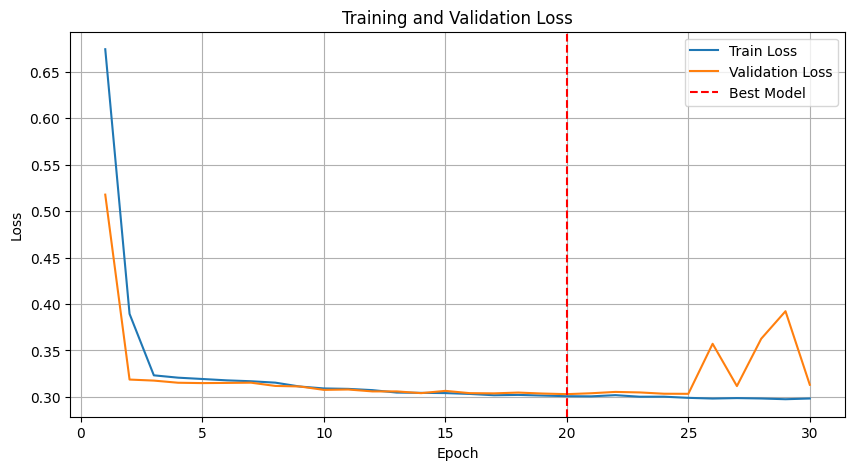

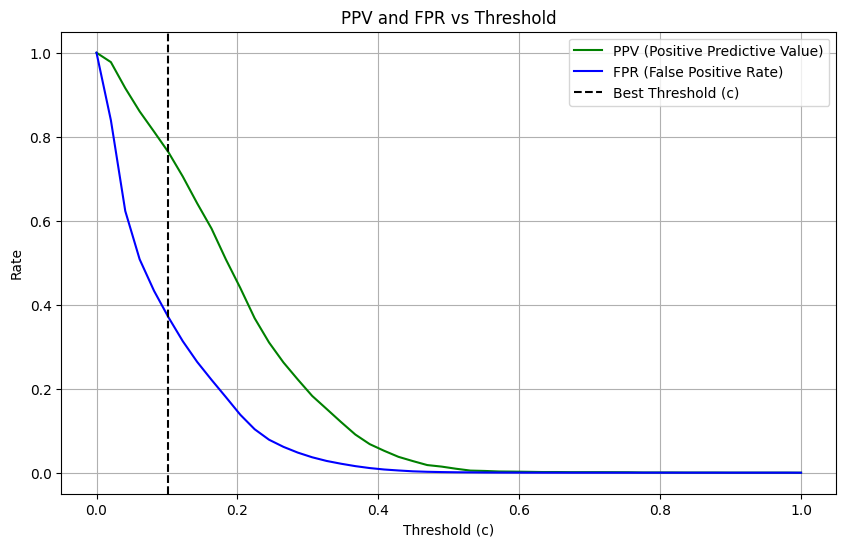

Best Threshold (c): 0.10
PPV at Best Threshold: 0.76
FPR at Best Threshold: 0.37


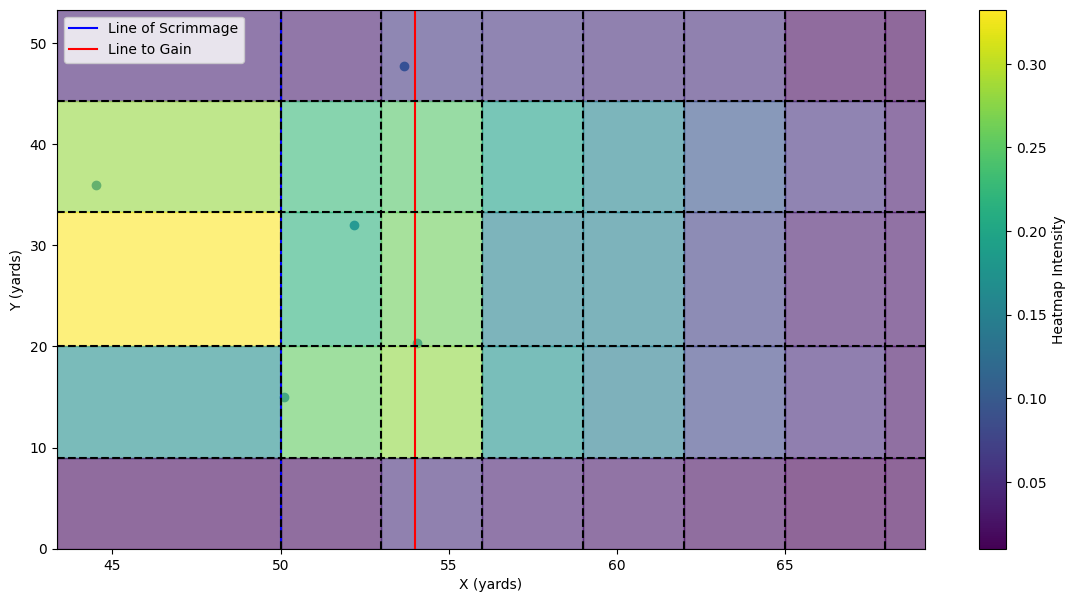

In [17]:
more_cutoffs = [0,3,6,9,12,15,18]
more_cutoff_type = 'yards'
#more_y_cutoffs = [5,10,15,20,25,30,35,40,45,50]
more_y_cutoffs = [9,20,33.3,44.3]
more_mature_matrices_dict = get_mature_matrices_dict(cutoffs = more_cutoffs,type=more_cutoff_type,y_cutoffs = more_y_cutoffs)

grids, labels, other_x, shape, ids = precompute_data(games,plays,full_tracking_data,more_mature_matrices_dict)
print("Other X Length:",len(other_x[1]))

# Step 1: Setup data
more_train_loader, more_val_loader, more_test_loader, shape = setup_data_from_precomputed(batch_size = 256,split_type='week',train_flip=True)

# Step 2: Train model
more_model_path = train_model(more_train_loader, more_val_loader, len(list(more_mature_matrices_dict.values())[0].flatten()), shape,
                         epochs = 100, print_every = 5, patience = 10, 
                         plot_losses=True, model_path="more_mod.pth")

# Step 3: Test model
more_best_c, more_best_tpr, more_best_fpr = test_model(more_test_loader, more_model_path, len(list(more_mature_matrices_dict.values())[0].flatten()),shape)

## Get the predictions
more_predictions = get_all_predictions(more_model_path,more_train_loader,more_val_loader,more_test_loader,len(list(more_mature_matrices_dict.values())[0].flatten()),more_mature_matrices_dict)
more_preds = plot_predictions(2022090800,3190,more_predictions,more_mature_matrices_dict,more_cutoffs,cutoff_type = more_cutoff_type,y_cutoffs = more_y_cutoffs)

In [18]:
# rel_cutoffs = [.2,.8,1.2,2]
# rel_cutoff_type = '%_ydstogo'
# rel_y_cutoffs = [9,20,33.3,44.3]
# rel_mature_matrices_dict = get_mature_matrices_dict(cutoffs = rel_cutoffs,type=rel_cutoff_type,y_cutoffs = rel_y_cutoffs)

# grids, labels, other_x, shape, ids = precompute_data(games,plays,full_tracking_data,rel_mature_matrices_dict)
# print("Other X Length:",len(other_x[1]))

# # Step 1: Setup data
# rel_train_loader, rel_val_loader, rel_test_loader, shape = setup_data_from_precomputed(batch_size = 256,split_type='week',train_flip=True)

# # Step 2: Train model
# rel_model_path = train_model(rel_train_loader, rel_val_loader, len(list(rel_mature_matrices_dict.values())[0].flatten()), shape,
#                          epochs = 100, print_every = 5, patience = 10, 
#                          plot_losses=True, model_path="rel_mod.pth")

# # Step 3: Test model
# rel_best_c, rel_best_tpr, rel_best_fpr = test_model(rel_test_loader, rel_model_path, len(list(rel_mature_matrices_dict.values())[0].flatten()),shape)

# ## Get the predictions
# rel_predictions = get_all_predictions(rel_model_path,rel_train_loader,rel_val_loader,rel_test_loader,len(list(rel_mature_matrices_dict.values())[0].flatten()),rel_mature_matrices_dict)
# rel_preds = plot_predictions(2022090800,3190,rel_predictions,rel_mature_matrices_dict,rel_cutoffs,cutoff_type = rel_cutoff_type,y_cutoffs=rel_y_cutoffs)

In [19]:
# display(orig_preds)
# display(more_preds)
# display(rel_preds)

In [20]:
# more_predictions.to_csv('pass_quad_preds_more.csv')

In [21]:
import os
import imageio
def animate_predictions(gameId,playId,predictions,mature_matrices_dict,cutoffs,cutoff_type,y_cutoffs):
    play_pred = predictions[(predictions['gameId'] == gameId) & (predictions['playId'] == playId)].iloc[0]
    play_info = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)].iloc[0]
    yardline = play_info['absoluteYardlineNumber']
    ydstogo = play_info['yardsToGo']
    tracking_data = full_tracking_data[(full_tracking_data['gameId'] == gameId) & (full_tracking_data['playId'] == playId)].copy()
    
    if cutoff_type == '%_ydstogo':
        for i in range(len(cutoffs)):
            cutoffs[i] = cutoffs[i] * ydstogo
    #print(cutoffs)
    direction = tracking_data.iloc[0]['playDirection']
    if direction == 'left':
        yardline = 120 - yardline
        
    truth = mature_matrices_dict[(gameId,playId)]
    
    #print(np.flip(truth.T,axis=1))
    num_classes = np.prod(truth.shape)
   
    preds = np.zeros(num_classes)
    for i in range(len(preds)):
        preds[i] = play_pred[f'pred_{i}']
    preds = preds.reshape(truth.shape)
    #print(np.flip(preds.T,axis=1))
    
    # Step 1: Compute the number of predictions to take
    num_preds_to_take = np.sum(truth)
    
    # Step 2: Get the indices of the top values
    top_indices = np.argsort(preds.flatten())[-int(num_preds_to_take):]  # Sorted indices of top values
    
    # Step 3: Retrieve the top values
    top_values = preds.flatten()[top_indices]
    
    n_frames = tracking_data['frameId'].max()
    if direction == 'left':
        tracking_data['x'] = 120 - tracking_data['x']
        tracking_data['y'] = 53.3 - tracking_data['y']

    ys = [0] + y_cutoffs + [53.3]
    ys = ys[::-1]
    preds = np.flip(preds.T,axis=1)

    # Generate and save individual frames
    for frame in tqdm(range(1, n_frames + 1)):
        frame_data = tracking_data[tracking_data['frameId'] == frame]
        offense = frame_data[frame_data['club'] == play_info['possessionTeam']]
        defense = frame_data[frame_data['club'] == play_info['defensiveTeam']]
        ball = frame_data[frame_data['displayName'] == 'football']
        # Create the figure
        fig, ax = plt.subplots(figsize=(14, 7))
        plt.scatter(offense['x'], offense['y'], c='blue', alpha=1)
        plt.scatter(defense['x'], defense['y'], c='red', alpha=1)
        plt.scatter(ball['x'],ball['y'],c='black',alpha=1)
        plt.xlim(tracking_data['x'].min() - 1, tracking_data['x'].max() + 1)
        plt.ylim(tracking_data['y'].min() - 1, tracking_data['y'].max() + 1)
        plt.title(f"Frame {frame}")
        plt.xlabel("X")
        plt.ylabel("Y")
        # Set up the grid for the heatmap
        x_edges = [yardline] + [yardline + c for c in cutoffs]
        y_edges = [9, 20, 33.3, 44.3, 53.3]  # Match the dashed y-lines + top edge
        
        # Line of scrimmage and line to gain
        ax.axvline(x=yardline, color='b', label='Line of Scrimmage')
        ax.axvline(x=yardline + ydstogo, color='r', label='Line to Gain')
        
        # Dashed lines
        for cutoff in y_cutoffs:
            ax.axhline(y=cutoff,color='k',linestyle='dashed')
    
        for cutoff in cutoffs:
            ax.axvline(x=yardline + cutoff, color='k', linestyle='dashed')
    
        xmin,xmax = ax.get_xlim()
    
        norm = plt.Normalize(preds.min(),preds.max())
        cmap = plt.cm.viridis  # Colormap
        
        #ys = [53.3,44.3,33.3,20,9,0]
        for row in range(preds.shape[0]):
            #print(preds[row,])
            for col in range(preds.shape[1]):
                if col == 0:
                    x = xmin
                else:
                    x = yardline + cutoffs[col - 1]
                y = ys[row+1]
    
                if col == (preds.shape[1] - 1):
                    width = xmax - xmin
                else:
                    width = (yardline + cutoffs[col]) - x
    
                height = ys[row] - y
                val = preds[preds.shape[0] - 1 - row, col]
                #print(x,y,width,height,val)
                if val in top_values:
                    # Get color based on heatmap value
                    color = 'yellow'
            
                    # Draw rectangle
                    rect = patches.Rectangle((x, y), width, height, color=color, alpha=0.4)
                    ax.add_patch(rect)
        
        # Add labels and legend
        ax.set_xlabel('X (yards)')
        ax.set_ylabel('Y (yards)')
        ax.legend()
        ax.set_ylim(0, 53.3)

        
        # Save the frame
        filename = os.path.join('./', f'frame_{frame:03d}.png')
        plt.savefig(filename)
        plt.close()

    # Compile frames into a GIF
    with imageio.get_writer('tracking_animation.gif', mode='I', duration=0.1) as writer:
        for frame in range(1, n_frames + 1):
            filename = os.path.join('./', f'frame_{frame:03d}.png')
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print("Animation saved as 'tracking_animation.gif'")


animate_predictions(2022090800,3190,more_predictions,more_mature_matrices_dict,more_cutoffs,cutoff_type = more_cutoff_type,y_cutoffs = more_y_cutoffs)

100%|██████████| 65/65 [00:18<00:00,  3.57it/s]
/tmp/ipykernel_17/913010177.py:125: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as 'tracking_animation.gif'


In [22]:
from IPython.display import HTML

HTML(f'<img src="./tracking_animation.gif" style="width:1200px;">')
